# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [42]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
from toolz import curry

from bokeh.io import show, output_notebook
from bokeh.charts import Bar
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import Rect
from toolz import curry
from bokeh.io import export_svgs
from IPython.display import SVG, display

%matplotlib inline 

/home/hoaphumanoid/anaconda3/envs/strata2/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


In [43]:
output_notebook()

Loading BokehJS ...

We are going to read the results from the following notebooks

In [2]:
notebooks = {
    'Airline':'01_airline.ipynb',
    'BCI': '02_BCI.ipynb',
    'Football': '03_football.ipynb',
    'Amazon': '04_PlanetKaggle.ipynb',
    'Fraud': '05_FraudDetection.ipynb'
}

In [3]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [26]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [30]:
def extract_text(cell):
    return cell['outputs'][0]['text']

In [31]:
@curry
def remove_line_with(match_str, json_string):
    return '\n'.join(filter(lambda x: match_str not in x, json_string.split('\n')))

In [33]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_text,
                remove_line_with('total RAM usage'),
                json.loads)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [34]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [35]:
results

{'Airline': {'lgbm': {'performance': {'AUC': 0.8087051409943042,
    'Accuracy': 0.7354971824736145,
    'F1': 0.6938324132201359,
    'Precision': 0.769944994990665,
    'Recall': 0.6314142306557513},
   'test_time': 15.056773265940137,
   'train_time': 331.96047770103905},
  'xgb': {'performance': {'AUC': 0.7853858629621876,
    'Accuracy': 0.6292093649533124,
    'F1': 0.6975436046496173,
    'Precision': 0.5691280104599091,
    'Recall': 0.9007951427442298},
   'test_time': 13.74539872200694,
   'train_time': 1995.4901636390714},
  'xgb_hist': {'performance': {'AUC': 0.8075987201449184,
    'Accuracy': 0.6736826732338557,
    'F1': 0.7169770760869618,
    'Precision': 0.6093457389543666,
    'Recall': 0.8707880911035721},
   'test_time': 14.146226429962553,
   'train_time': 544.1617271649884}},
 'Amazon': {'lgbm': {'performance': {'Accuracy': 0.6243840116809637,
    'F1': 0.8979655091719337,
    'Precision': 0.9232276484238522,
    'Recall': 0.890522688359885},
   'test_time': 0.85

We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [36]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    return 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()

In [37]:
def train_time_ratio(dataset):
    return dataset['xgb']['train_time']/dataset['lgbm']['train_time']

def test_time_ratio(dataset):
    return dataset['xgb']['test_time']/dataset['lgbm']['test_time']

In [38]:
metrics = juxt(average_performance_diff, train_time_ratio, test_time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [39]:
results_df = pd.DataFrame(res_per_dataset, index=['Perf. Difference(%)', 
                                                  'Train Time Ratio', 
                                                  'Test Time Ratio']).T

In [40]:
results_df

,Perf. Difference(%),Train Time Ratio,Test Time Ratio
Airline,0.043738,6.011228,0.912905
Amazon,0.208313,4.035401,2.976076
BCI,6.250871,2.503829,0.711396
Football,-0.589916,3.617075,0.555471
Fraud,-1.076624,6.045945,1.060074


In [70]:
data = {
    'Train Time Ratio': results_df['Train Time Ratio'].values,
    'label': results_df.index.values
}

In [71]:
bar = Bar(data, values='Train Time Ratio', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Train Time Ratio'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

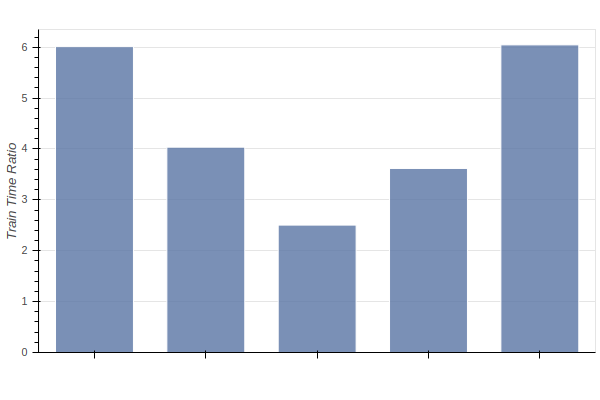

In [72]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time.svg")
display(SVG('xgb_vs_lgbm_train_time.svg'))

In [74]:
data = {
    'Perf. Difference(%)': results_df['Perf. Difference(%)'].values,
    'label': results_df.index.values
}

In [75]:
bar = Bar(data, values='Perf. Difference(%)', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Perf. Difference(%)'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

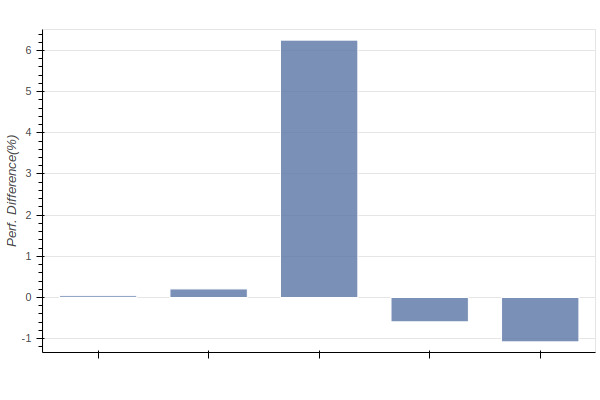

In [76]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_performance.svg")
display(SVG('xgb_vs_lgbm_performance.svg'))

From the table as well as the plots below we can see that overall the difference in performance is quite small. LightGBM though is 2 to over 10 times quicker than XGBoost.